In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import networkx as nx
from random import shuffle

from pydivest.macro_model.integrate_equations_rep import Integrate_Equations as rep
from pydivest.macro_model.integrate_equations_aggregate import Integrate_Equations as agg
from pydivest.macro_model.integrate_equations_mean import Integrate_Equations as mean
from pydivest.micro_model.divestmentcore import DivestmentCore as micro

Could not find GLIMDA


In [2]:
# investment_decisions:

possible_cue_orders = [[0], [1]]

# Parameters:

input_parameters = {'i_tau': 1, 'eps': 0.001, 'b_d': 1.2,
                    'b_c': 1., 'i_phi': .5, 'e': 10,
                    'G_0': 10000, 'b_r0': 0.1 ** 2 * 100,
                    'possible_cue_orders': possible_cue_orders,
                    'C': 100, 'xi': 1. / 8., 'd_c': 0.06, 's': 0.23,
                    'campaign': False, 'learning': True,
                    'crs': True}

# investment_decisions
nopinions = [50, 50]
opinions = []
for i, n in enumerate(nopinions):
    opinions.append(np.full((n), i, dtype='I'))
opinions = [item for sublist in opinions for item in sublist]
shuffle(opinions)

# network:
N = sum(nopinions)
p = .2

while True:
    net = nx.erdos_renyi_graph(N, p)
    if len(list(net)) > 1:
        break
adjacency_matrix = nx.adj_matrix(net).toarray()

# investment
clean_investment = np.ones(N)
dirty_investment = np.ones(N)

init_conditions = (adjacency_matrix, opinions,
                   clean_investment, dirty_investment)

models = {}

models['rep'] = rep(*init_conditions, **input_parameters)
C, n = models['rep'].find_initial_conditions()

input_parameters['C'] = C

# investment_decisions
nopinions = [int(round((1.-n) * 100.)), int(round(n * 100.))]
opinions = []
for i, n in enumerate(nopinions):
    opinions.append(np.full((n), i, dtype='I'))
opinions = [item for sublist in opinions for item in sublist]
shuffle(opinions)

# network:
N = sum(nopinions)
p = .2

while True:
    net = nx.erdos_renyi_graph(N, p)
    if len(list(net)) > 1:
        break
adjacency_matrix = nx.adj_matrix(net).toarray()

init_conditions = (adjacency_matrix, opinions,
                   clean_investment, dirty_investment)

models['agg'] = agg(*init_conditions, **input_parameters)

models['mean'] = mean(*init_conditions, **input_parameters)

for name in models:
    print(models[name].subs_params)

got superfluous keyword arguments
dict_keys(['possible_cue_orders', 'campaign', 'learning'])
pi = 0.5, xi = 0.125, kappa_c = 0.375, kappa_d = 0.5
sanitizing initial conditions to
{K_c: 100.0, K_d: 100.0, G: 10000.0, C: 584.98535041007551, n: 0.46134028954765216}
got superfluous keyword arguments
dict_keys(['possible_cue_orders', 'campaign', 'learning'])
pi = 0.5, xi = 0.125, kappa_c = 0.375, kappa_d = 0.5
define economic equations,
saving rhs successful
got superfluous keyword arguments
dict_keys(['possible_cue_orders', 'campaign', 'learning'])
pi = 0.5, xi = 0.125, kappa_c = 0.375, kappa_d = 0.5
simplify PBP rhs
simplifying eco switch terms
saving rhs successful
{b_c: 1.0, b_d: 1.2, b_R: 1.0000000000000002, e: 10.0, s: 0.23, delta: 0.06, pi: 0.5, kappa_c: 0.375, kappa_d: 0.5, xi: 0.125, mu: 2.0, G_0: 10000.0, L: 100.0}
{b_c: 1.0, b_d: 1.2, b_R: 1.0000000000000002, e: 10.0, s: 0.23, delta: 0.06, pi: 0.5, kappa_c: 0.375, kappa_d: 0.5, xi: 0.125, G_0: 10000.0, L: 100.0, epsilon: 0.001, p

In [3]:
t_max = 20

models['micro'] = micro(*init_conditions, **input_parameters)

#m_names = ['micro', 'mean']
#m_names = ['micro', 'agg']
m_names = ['mean', 'agg', 'micro']
#m_names = ['micro', 'mean', 'agg', 'rep']

for name in m_names:
    if name in ['mean', 'agg']:
        models[name].run(t_max=t_max, t_steps=40)
    else:
        models[name].run(t_max=t_max)

integrating equations from t=0 to t=20
integrating equations from t=0 to t=20=======================] 100.3% ...mean approximation running


In [4]:
trajectories = {}

for name in m_names:
    print(name)
    trajectories[name] = models[name].get_unified_trajectory()

mean
agg
micro


<IPython.core.display.Javascript object>


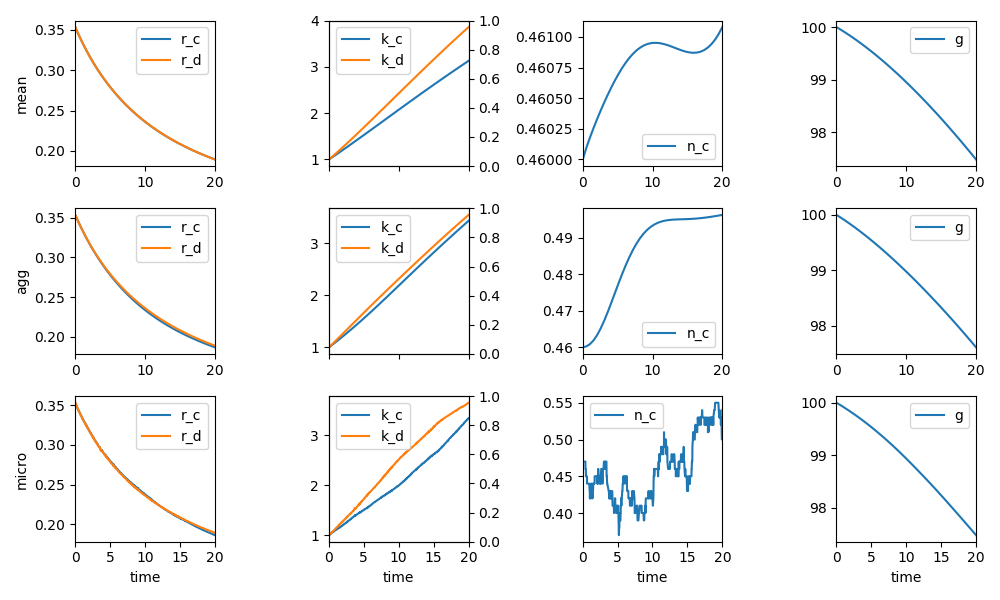

In [5]:
fig = plt.figure(figsize=(10,2 * len(m_names)))

t_max = 20

for i, name in enumerate(m_names):
    trj = trajectories[name][:t_max]

    ax = fig.add_subplot(len(m_names), 4, 1 + 4*i)
    ax.set_ylabel(name)
    trj[['r_c', 'r_d']].plot(ax=ax)
    leg = ax.get_legend()
    leg.set_bbox_to_anchor(bbox=(1,1))

    ax2 = fig.add_subplot(len(m_names), 4, 2 + 4*i)
    trj[['k_c', 'k_d']].plot(ax=ax2)
    ax2b = ax2.twinx()
    #trj[['c']].plot(ax=ax2b, color='g')

    ax3 = fig.add_subplot(len(m_names), 4, 3 + 4*i)
    trj[['n_c']].plot(ax=ax3)
    
    ax4 = fig.add_subplot(len(m_names), 4, 4 + 4*i)
    trj[['g']].plot(ax=ax4)

    fig.tight_layout()

<IPython.core.display.Javascript object>


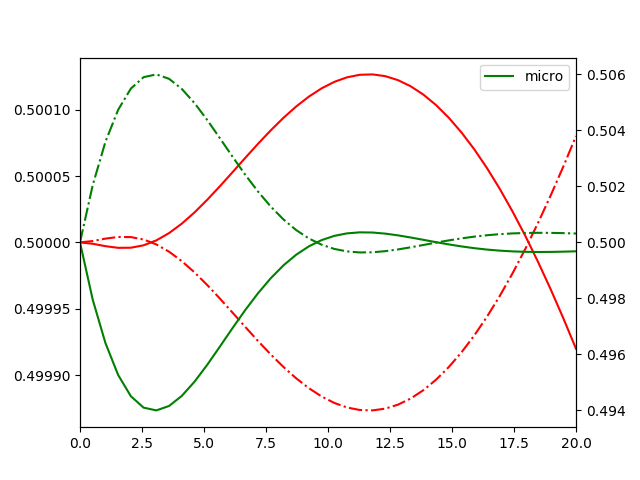

In [6]:
fig, ax = plt.subplots()

colors = 'rgb'
axb = ax.twinx()

trj = trajectories['mean']
trj['Pcd'].plot(ax=ax, color='r', label=name)
trj['Pdc'].plot(ax=ax, color='r', style='-.', label='__no_label__')
trj = trajectories['agg']
trj['Pcd'].plot(ax=axb, color='g', label=name)
trj['Pdc'].plot(ax=axb, color='g', style='-.', label='__no_label__')

plt.legend()

<IPython.core.display.Javascript object>


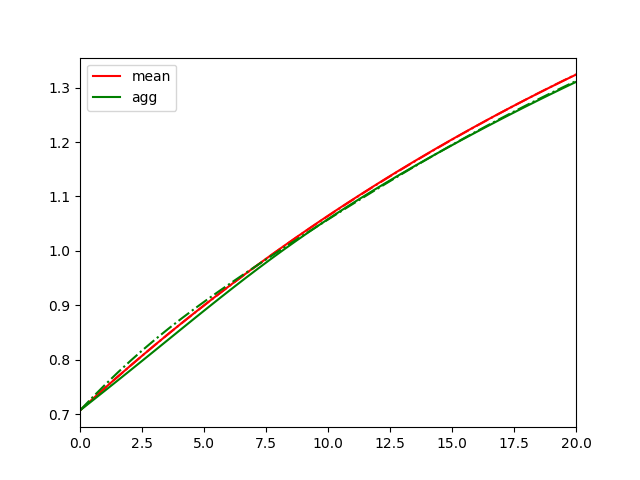

In [7]:
fig, ax = plt.subplots()

colors = 'rgb'

for i, name in enumerate(m_names):
    if not name == 'micro':
        trj = trajectories[name]
        trj['W_d'].plot(ax=ax, color=colors[i], label=name)
        trj['W_c'].plot(ax=ax, color=colors[i], style='-.', label='__no_label__')
        plt.legend()

<IPython.core.display.Javascript object>


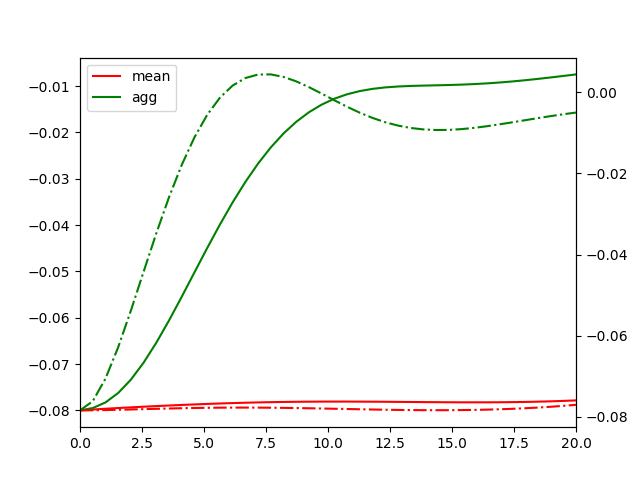

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = 'rgbk'
m_names.pop(-1)
trjs = {}
trjs['mean'] = models['mean'].get_mean_trajectory()
trjs['agg'] = models['agg'].get_aggregate_trajectory()

for i, name in enumerate(m_names):
    trj = trjs[name]
    trj['x'].plot(ax=ax, color=colors[i], label=name)
    #trj['z'].plot(ax=ax, color=colors[i], style='--', label='__no_label__')
plt.legend()

axb = ax.twinx()
for i, name in enumerate(m_names):
    trj = trjs[name]
    trj['y'].plot(ax=axb, color=colors[i], style='-.', label='__no_label__')

<IPython.core.display.Javascript object>


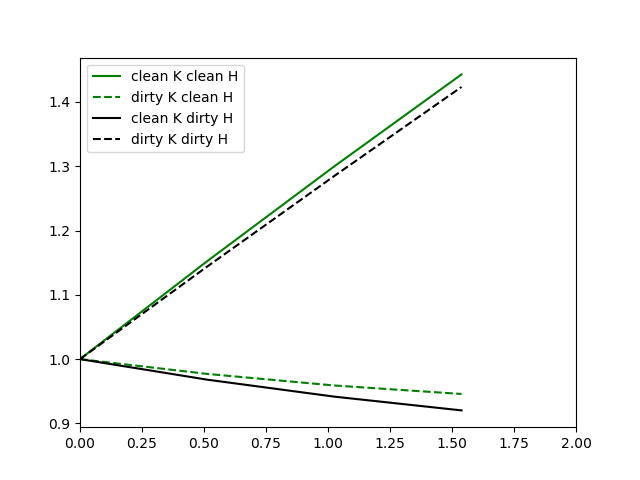

In [9]:
fig, ax = plt.subplots()
(trjs['agg'][:2]['K_c^c']/(100*0.5*(trjs['agg']['x'] + 1))).plot(color='g', style='-', label='clean K clean H')
(trjs['agg'][:2]['K_d^c']/(100*0.5*(trjs['agg']['x'] + 1))).plot(color='g', style='--', label='dirty K clean H')
(trjs['agg'][:2]['K_c^d']/(100*0.5*(1 - trjs['agg']['x']))).plot(color='k', style='-', label='clean K dirty H')
(trjs['agg'][:2]['K_d^d']/(100*0.5*(1 - trjs['agg']['x']))).plot(color='k', style='--', label='dirty K dirty H')
ax.set_xlim([0, 2])
plt.legend()

<IPython.core.display.Javascript object>


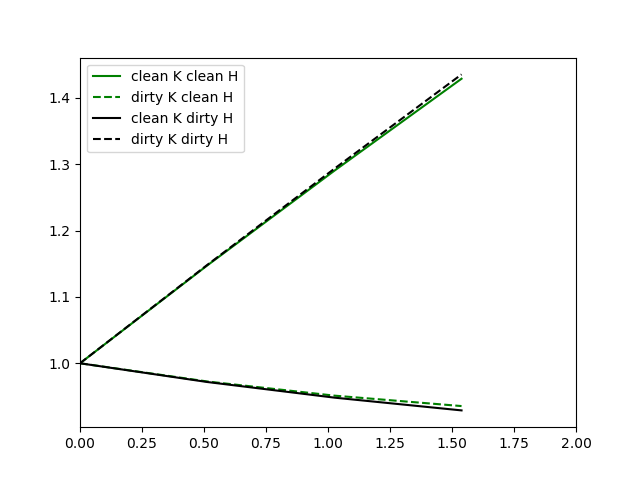

In [10]:
fig, ax = plt.subplots()
(trjs['mean'][:2]['mu_c^c']).plot(color='g', style='-', label='clean K clean H')
(trjs['mean'][:2]['mu_d^c']).plot(color='g', style='--', label='dirty K clean H')
(trjs['mean'][:2]['mu_c^d']).plot(color='k', style='-', label='clean K dirty H')
(trjs['mean'][:2]['mu_d^d']).plot(color='k', style='--', label='dirty K dirty H')
ax.set_xlim([0, 2])
plt.legend()

<IPython.core.display.Javascript object>


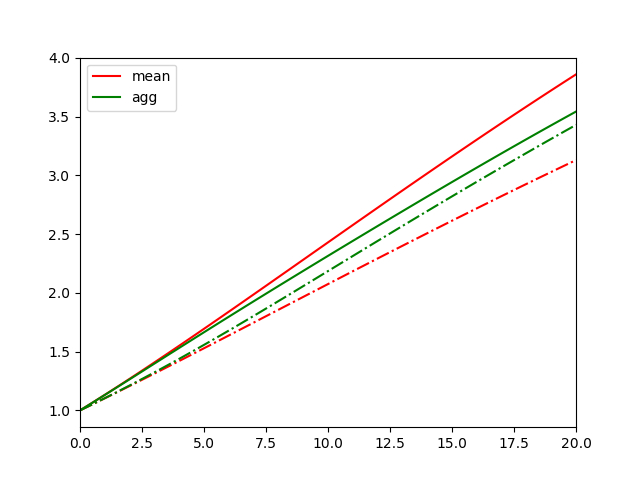

In [11]:
fig, ax = plt.subplots()


for i, name in enumerate(m_names):
    trj = trajectories[name]
    trj['k_d'].plot(ax=ax, color=colors[i], label=name)
    trj['k_c'].plot(ax=ax, color=colors[i], style='-.', label='__no_label__')
    plt.legend()

<IPython.core.display.Javascript object>


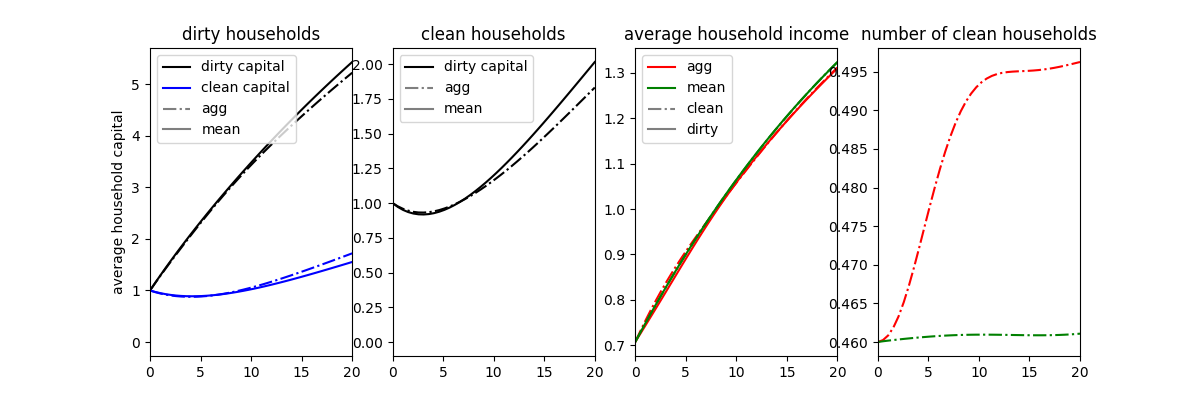

/home/jakob/anaconda3/envs/forge/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [12]:
tra = models['agg'].get_aggregate_trajectory()
trm = models['mean'].get_mean_trajectory()

fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(141)
ax.set_title('dirty households')
ax.set_ylabel('average household capital')
(2./100*tra['K_d^d']/(1-tra['x'])).plot(ax=ax, color='k', style='-.', label='__no_label__')
trm['mu_d^d'].plot(ax=ax, color='k', label='dirty capital')
(2./100*tra['K_c^d']/(1-tra['x'])).plot(ax=ax, color='b', style='-.', label='__no_label__')
trm['mu_c^d'].plot(ax=ax, color='b', label='clean capital')
ax.plot([0], [0], 'k-.', label='agg', alpha=.5)
ax.plot([0], [0], 'k-', label='mean', alpha=.5)
plt.legend()

ax2=fig.add_subplot(142)
ax2.set_title('clean households')
(2./100*tra['K_d^c']/(1+tra['x'])).plot(ax=ax2, color='k', style='-.', label='__no_label__')
trm['mu_d^c'].plot(ax=ax2, color='k', label='dirty capital')
#(2./100*tra['K_c^c']/(1+tra['x'])).plot(ax=ax2, color='b', style='-.', label='__no_label__')
#trm['mu_c^c'].plot(ax=ax2, color='b', label='clean capital')
ax2.plot([0], [0], 'k-.', label='agg', alpha=.5)
ax2.plot([0], [0], 'k-', label='mean', alpha=.5)
plt.legend()

ax3 = fig.add_subplot(143)
ax3.set_title('average household income')
for i, name in enumerate(['agg', 'mean']):
    trj = trajectories[name]
    trj['W_d'].plot(ax=ax3, color=colors[i], label=name)
    trj['W_c'].plot(ax=ax3, color=colors[i], style='-.', label='__no_label__')
ax3.plot([0], [0.707], 'k-.', label='clean', alpha=.5)
ax3.plot([0], [0.707], 'k-', label='dirty', alpha=.5)
plt.legend()
    
ax4 = fig.add_subplot(144)
ax4.set_title('number of clean households')
for i, name in enumerate(['agg', 'mean']):
    trj = trajectories[name]
    trj['n_c'].plot(ax=ax4, color=colors[i], style='-.', label='__no_label__')
    plt.legend()

<IPython.core.display.Javascript object>


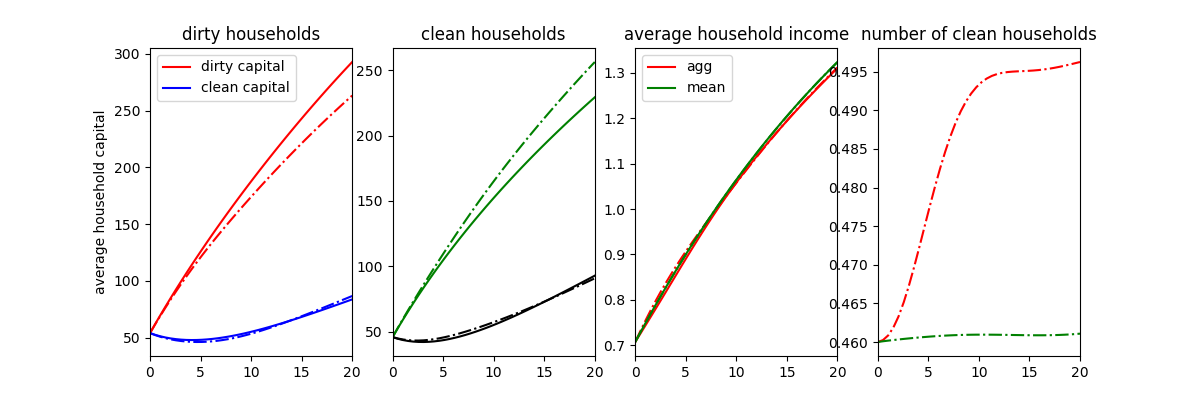

/home/jakob/anaconda3/envs/forge/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [13]:
tra = models['agg'].get_aggregate_trajectory()
trm = models['mean'].get_mean_trajectory()

fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(141)
ax.set_title('dirty households')
ax.set_ylabel('average household capital')
tra['K_d^d'].plot(ax=ax, color='r', style='-.', label='__no_label__')
(trm['mu_d^d']*100/2*(1-trm['x'])).plot(ax=ax, color='r', label='dirty capital')
tra['K_c^d'].plot(ax=ax, color='b', style='-.', label='__no_label__')
(trm['mu_c^d']*100/2*(1-trm['x'])).plot(ax=ax, color='b', label='clean capital')
plt.legend()

ax2=fig.add_subplot(142)
ax2.set_title('clean households')
tra['K_c^c'].plot(ax=ax2, color='g', style='-.')
(trm['mu_c^c']*100/2*(1+trm['x'])).plot(ax=ax2, color='g')
tra['K_d^c'].plot(ax=ax2, color='k', style='-.')
(trm['mu_d^c']*100/2*(1+trm['x'])).plot(ax=ax2, color='k')

ax3 = fig.add_subplot(143)
ax3.set_title('average household income')
for i, name in enumerate(['agg', 'mean']):
    trj = trajectories[name]
    trj['W_d'].plot(ax=ax3, color=colors[i], label=name)
    trj['W_c'].plot(ax=ax3, color=colors[i], style='-.', label='__no_label__')
    plt.legend()
    
ax4 = fig.add_subplot(144)
ax4.set_title('number of clean households')
for i, name in enumerate(['agg', 'mean']):
    trj = trajectories[name]
    trj['n_c'].plot(ax=ax4, color=colors[i], style='-.', label='__no_label__')
    plt.legend()